In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D

import tensorflow as tf

import os
import pickle
import numpy as np

Using TensorFlow backend.


In [2]:
print(tf.__version__)
print(keras.__version__)

1.2.1
2.0.6


In [3]:
batch_size = 32
num_classes = 10
epochs = 50
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_simple_CNN.h5'

## Load the dataset


In [4]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


In [5]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## The Model

In [6]:

Inp = Input(shape=(32,32,3),name = 'Input_layer')

#ConvBlock 01
conv01 = Conv2D(32, (3, 3), padding='same',activation = 'relu', input_shape=Inp.shape,name = 'Conv01_layer')(Inp)
conv02 = Conv2D(32, (3, 3),activation = 'relu',name = 'Conv02_layer')(conv01)
maxpool_01 = MaxPooling2D(pool_size=(2, 2),name = 'MaxPool01_layer')(conv02)
drop01 = Dropout(0.25,name = 'Dropout01_layer')(maxpool_01)

#Convblock 02
conv03 = Conv2D(64, (3, 3), padding='same',activation = 'relu',name = 'Conv03_layer')(drop01)
conv04 = Conv2D(64, (3, 3),activation = 'relu',name = 'Conv04_layer')(conv03)
maxpool_02 = MaxPooling2D(pool_size=(2, 2),name = 'MaxPool02_layer')(conv04)
drop02 = Dropout(0.25,name = 'Dropout02_layer')(maxpool_02)

# Fully Connected Dense block
x = Flatten(name = 'Flatten_layer')(drop02)
x = Dense(512, activation='relu',name = 'Dense01_layer')(x)
x = Dropout(0.5,name = 'Dropout03_layer')(x)
logits_layer = Dense(num_classes, name= 'logits_layer')(x)
output = Activation('softmax',name = 'Sofftmax_layer')(logits_layer)

In [7]:
# Define model inputs and output
model = Model(Inp, output)

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     (None, 32, 32, 3)         0         
_________________________________________________________________
Conv01_layer (Conv2D)        (None, 32, 32, 32)        896       
_________________________________________________________________
Conv02_layer (Conv2D)        (None, 30, 30, 32)        9248      
_________________________________________________________________
MaxPool01_layer (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
Dropout01_layer (Dropout)    (None, 15, 15, 32)        0         
_________________________________________________________________
Conv03_layer (Conv2D)        (None, 15, 15, 64)        18496     
_________________________________________________________________
Conv04_layer (Conv2D)        (None, 13, 13, 64)        36928     
__________

In [9]:
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

## DATA Preproc

In [10]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [11]:
print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

Using real-time data augmentation.


In [12]:
# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

In [13]:
# Fit the model on the batches generated by datagen.flow().
hist = model.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    workers=4)


Epoch 1/50
1562/1562 [==============================] - 10s - loss: 1.8808 - acc: 0.3074 - val_loss: 1.6244 - val_acc: 0.4187
Epoch 2/50
1562/1562 [==============================] - 10s - loss: 1.6357 - acc: 0.4021 - val_loss: 1.4125 - val_acc: 0.4895
Epoch 3/50
1562/1562 [==============================] - 10s - loss: 1.5252 - acc: 0.4460 - val_loss: 1.3133 - val_acc: 0.5376
Epoch 4/50
1562/1562 [==============================] - 10s - loss: 1.4424 - acc: 0.4809 - val_loss: 1.2718 - val_acc: 0.5538
Epoch 5/50
1562/1562 [==============================] - 10s - loss: 1.3830 - acc: 0.5057 - val_loss: 1.1873 - val_acc: 0.5769
Epoch 6/50
1562/1562 [==============================] - 10s - loss: 1.3339 - acc: 0.5233 - val_loss: 1.1289 - val_acc: 0.6026
Epoch 7/50
1562/1562 [==============================] - 10s - loss: 1.2951 - acc: 0.5397 - val_loss: 1.0804 - val_acc: 0.6219
Epoch 8/50
1562/1562 [==============================] - 10s - loss: 1.2567 - acc: 0.5525 - val_loss: 1.0846 - val_acc:

In [14]:
def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)
    

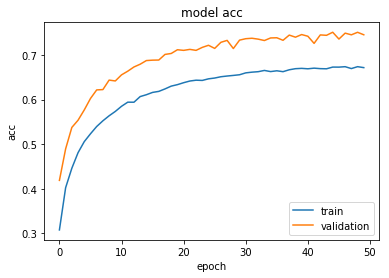

In [15]:
plot_train(hist)

In [16]:
# Load label names to use in prediction results
label_list_path = 'datasets/cifar-10-batches-py/batches.meta'

keras_dir = os.path.expanduser(os.path.join('~', '.keras'))
datadir_base = os.path.expanduser(keras_dir)
if not os.access(datadir_base, os.W_OK):
    datadir_base = os.path.join('/tmp', '.keras')
label_list_path = os.path.join(datadir_base, label_list_path)

with open(label_list_path, mode='rb') as f:
    labels = pickle.load(f)

## Evaluate the model

In [17]:
# Evaluate model with test data set and share sample prediction results
evaluation = model.evaluate_generator(datagen.flow(x_test, y_test,
                                                   batch_size=batch_size,
                                                   shuffle=False),
                                      steps=x_test.shape[0] // batch_size,
                                      workers=4)
print('Model Accuracy = %.2f' % (evaluation[1]))
print('Model Loss = %.2f' % (evaluation[0]))

Model Accuracy = 0.69


## Make predictions

In [18]:
predict_gen = model.predict_generator(datagen.flow(x_test, y_test,
                                                   batch_size=batch_size,
                                                   shuffle=False),
                                      steps=x_test.shape[0] // batch_size,
                                      workers=4)

In [21]:
predict_gen = predict_gen[20:]

In [22]:
for predict_index, predicted_y in enumerate(predict_gen):
    actual_label = labels['label_names'][np.argmax(y_test[predict_index])]
    predicted_label = labels['label_names'][np.argmax(predicted_y)]
    print('Actual Label = %s vs. Predicted Label = %s' % (actual_label,
                                                          predicted_label))
    if predict_index == num_predictions:
        break

Actual Label = cat vs. Predicted Label = dog
Actual Label = ship vs. Predicted Label = cat
Actual Label = ship vs. Predicted Label = ship
Actual Label = airplane vs. Predicted Label = ship
Actual Label = frog vs. Predicted Label = horse
Actual Label = frog vs. Predicted Label = frog
Actual Label = automobile vs. Predicted Label = dog
Actual Label = frog vs. Predicted Label = dog
Actual Label = cat vs. Predicted Label = horse
Actual Label = automobile vs. Predicted Label = dog
Actual Label = airplane vs. Predicted Label = frog
Actual Label = truck vs. Predicted Label = cat
Actual Label = dog vs. Predicted Label = frog
Actual Label = horse vs. Predicted Label = frog
Actual Label = truck vs. Predicted Label = ship
Actual Label = ship vs. Predicted Label = airplane
Actual Label = dog vs. Predicted Label = cat
Actual Label = horse vs. Predicted Label = airplane
Actual Label = ship vs. Predicted Label = airplane
Actual Label = frog vs. Predicted Label = frog
Actual Label = horse vs. Predicte

In [20]:
predict_gen.shape

(9968, 10)